## Split Population Exponential Fitness Function Simulations

In [1]:
import os
import sys
import glob
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
from multiprocessing import Pool
from functools import partial
import pandas as pd
import scipy
import pickle
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from matplotlib.patches import Polygon
from matplotlib import cm
import matplotlib as mpl
import matplotlib.colors as mcolors

In [279]:
from cvtk.cvtk import TemporalFreqs, TiledTemporalFreqs
from cvtk.cov import stack_temporal_covariances
import cvtk.slimfile as sf
from cvtk.process_sims import extract_runs, load_pickled, load_stats, CI_polygon
from cvtk.process_sims import params_vary_over, col_palette, average_runs
from cvtk.process_sims import covs_from_twopop
from cvtk.gintervals import GenomicIntervals
from cvtk.plots import rep_plot_pca, correction_diagnostic_plot
from cvtk.utils import integerize
from cvtk.cov import stack_replicate_covariances, stack_temporal_covs_by_group

In [4]:
lowess = sm.nonparametric.lowess

In [5]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.figsize'] = (8.0, 4.0)
mpl.rcParams['figure.dpi'] = 200
plt.style.use('plots/buffalo.mplstyle')

In [6]:
DATADIR = "../data/sims_intermediate/split_exp/"
SIMDIR = "../data/sims/split_exp/"

In [7]:
converters = dict(N=int, alpha=float, nmu=float, rbp=float, tmu=float,
                  mag=float, Va=float, L = int,
                  region_length=int, sampleN=int, shifttime=int, tail=float)
expfit_results = load_pickled(DATADIR, converters=converters, add_in_Va=True)
expfit_stats_orig = load_stats(SIMDIR, converters=converters, add_in_Va=True)

In [8]:
# we didn't process covariances for all parameters (e.g. N=100 and rbp=5e-9 excluded for now)
# so we subset:
expfit_stats = defaultdict(list)
for key in expfit_results:
    expfit_stats[key].extend(expfit_stats_orig[key])

In [9]:
len(expfit_results.keys())

240

In [10]:
len(expfit_stats.keys())

240

In [11]:
assert(set(expfit_results.keys()) == set(expfit_stats.keys()))

## Response to Selection under Different Parameters

In [12]:
params_vary_over(expfit_results)

defaultdict(set,
            {'L': {1, 10, 100, 1000},
             'N': {1000},
             'Va': {0.0, 0.001, 0.005, 0.01},
             'alpha': {0.0,
              0.00286,
              0.006394,
              0.009043,
              0.02022,
              0.0286,
              0.06394,
              0.09043,
              0.2022,
              0.286},
             'mag': {1.0},
             'nmu': {1e-08},
             'rbp': {1e-08},
             'region_length': {50000000},
             'sampleN': {50, 100, 200, 500, 1000},
             'shifttime': {5},
             'shifttype': {'converge', 'diverge', 'single'},
             'tmu': {0.0, 6.114e-13, 6.114e-12, 6.114e-11, 6.114e-10}})

In [13]:
stats_subset = extract_runs({'mag': [1.0], 'sampleN': [1000], 'Va': [0.001, 0.005, 0.01],
                             'shifttype': ['converge'], 'L': [1, 100, 1000]},
                            expfit_stats)
subset_params = params_vary_over(stats_subset)
subset_params

defaultdict(set,
            {'L': {1, 100, 1000},
             'N': {1000},
             'Va': {0.001, 0.005, 0.01},
             'alpha': {0.00286,
              0.006394,
              0.009043,
              0.02022,
              0.0286,
              0.09043,
              0.2022,
              0.286},
             'mag': {1.0},
             'nmu': {1e-08},
             'rbp': {1e-08},
             'region_length': {50000000},
             'sampleN': {1000},
             'shifttime': {5},
             'shifttype': {'converge'},
             'tmu': {6.114e-13, 6.114e-11, 6.114e-10}})

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


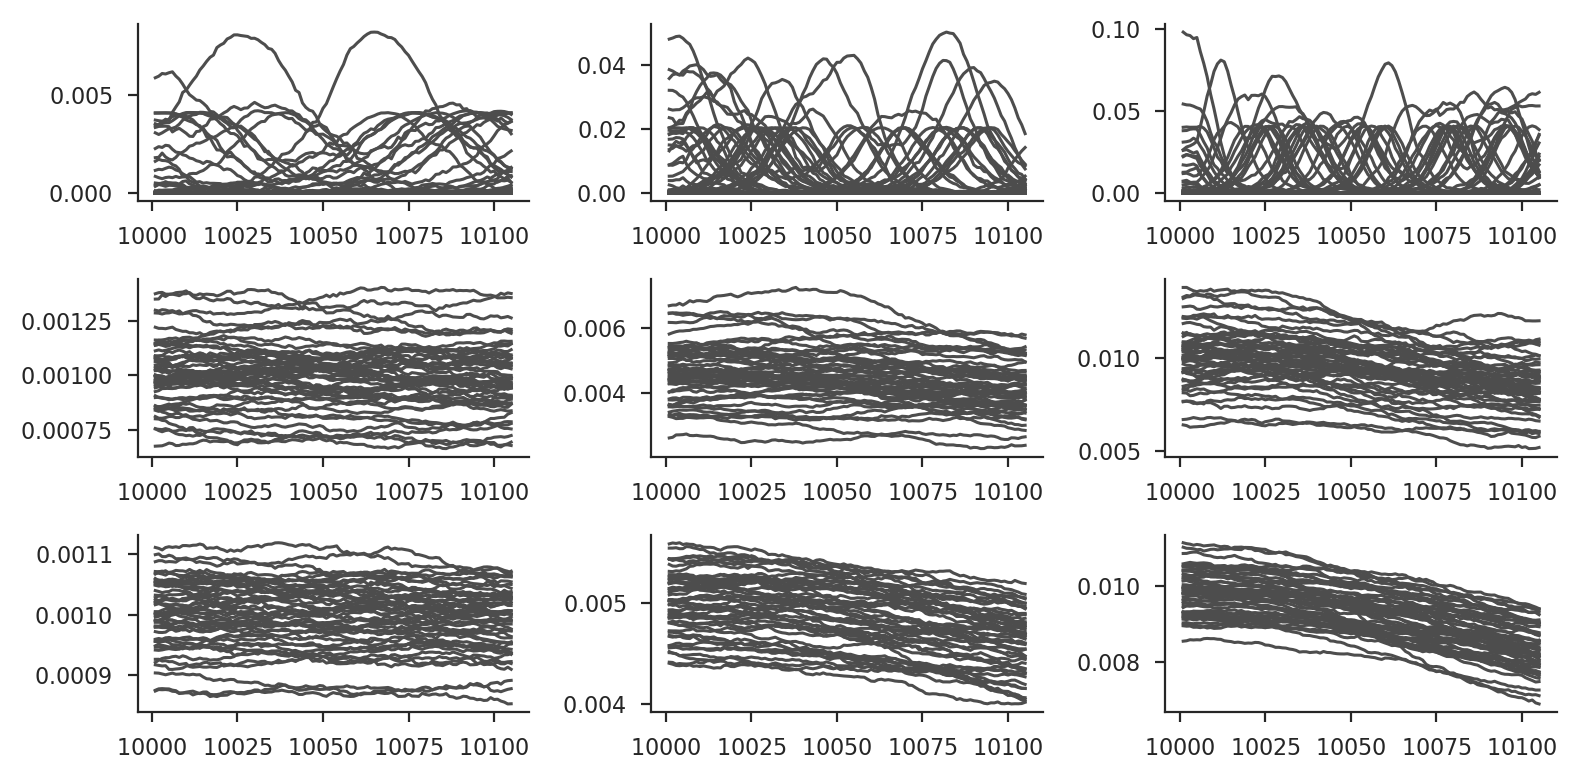

In [14]:
fix, ax = plt.subplots(nrows = 3, ncols=3)

Ls = sorted(subset_params['L'])
Vas = sorted(subset_params['Va'])

for i, L in enumerate(Ls):
    for j, Va in enumerate(Vas):
        d = extract_runs({'Va':[Va], 'L':[L]}, stats_subset)
        assert(len(d.keys()) == 1)
        for run in list(d.values())[0]:
            ax[i, j].plot(run.generation, run.genic_va_1, c='0.3')

plt.tight_layout()

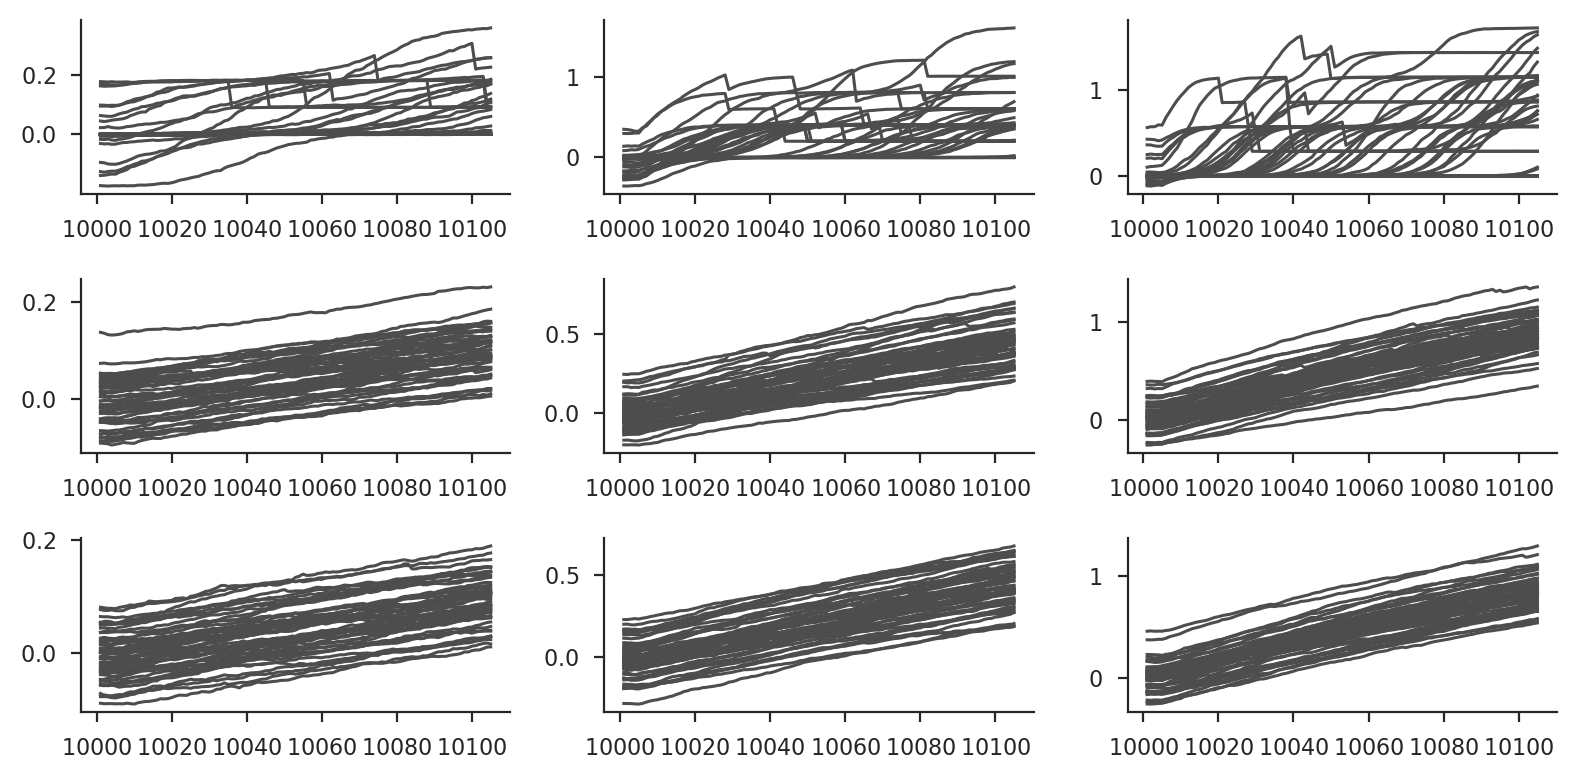

In [15]:
fix, ax = plt.subplots(nrows = 3, ncols=3)

Ls = sorted(subset_params['L'])
Vas = sorted(subset_params['Va'])

for i, L in enumerate(Ls):
    for j, Va in enumerate(Vas):
        d = extract_runs({'Va':[Va], 'L':[L]}, stats_subset)
        assert(len(d.keys()) == 1)
        for run in list(d.values())[0]:
            ax[i, j].plot(run.generation, run.zbar_1, c='0.3')
            
plt.tight_layout()

## Covariances and G

In [232]:
covs_subset = extract_runs({'mag': [1.0], 'sampleN': [1000], 'Va': [0.001, 0.005, 0.01],
                             'shifttype': ['converge'], 'L': [1, 100, 1000]},
                              expfit_results)

### G

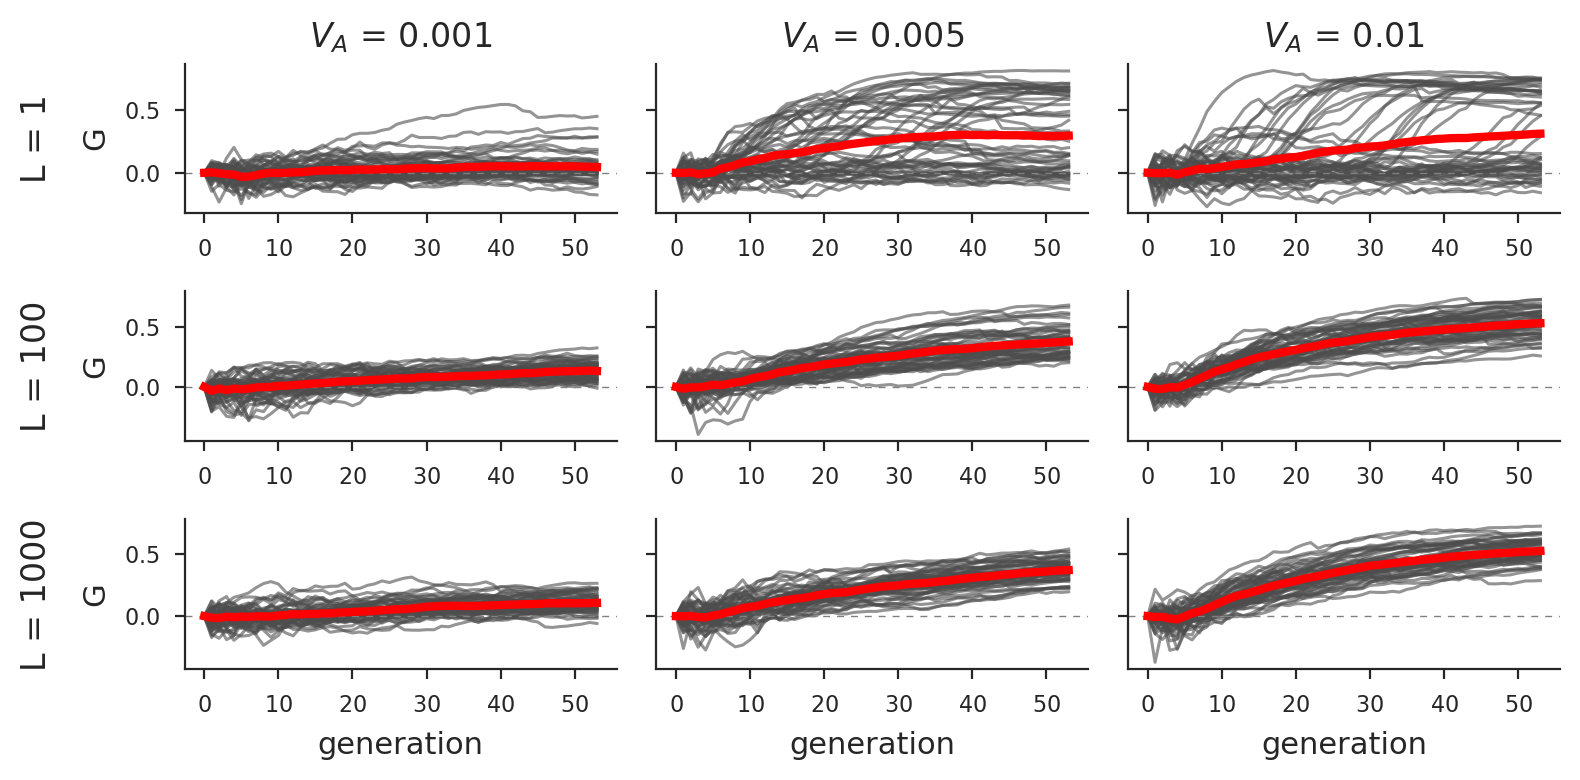

In [239]:
fig, ax = plt.subplots(nrows = 3, ncols=3, sharey='row')

Ls = sorted(subset_params['L'])
Vas = sorted(subset_params['Va'])
pad = 5

for i, L in enumerate(Ls):
    for j, Va in enumerate(Vas):
        d = extract_runs({'Va':[Va], 'L':[L]}, covs_subset)
        assert(len(d.keys()) == 1)
        all = []
        for run in list(d.values())[0]:
            ax[i, j].plot(run[1][:, 0], c='0.3', alpha=0.6)
            #ax[i, j].set_title(f"L = {L}, Va = {Va}")
            if j == 0:
                ax[i, j].set_ylabel('G')
            if i == 2:
                ax[i, j].set_xlabel('generation')
            all.append(run[1][:, 0])
        ax[i, j].axhline(0, c='0.5', linewidth=0.5, linestyle=(0, (5, 5)))   
        ax[i, j].plot(np.stack(all).mean(axis=0), c='r', linewidth=3)
        if i == 0:
            ax[i, j].set_title(f"$V_A$ = {Va}")
    ax[i, 0].annotate(f"L = {L}", xy=(0, 0.5), 
                      xytext=(-ax[i, 0].yaxis.labelpad - pad, 0),
                      xycoords=ax[i, 0].yaxis.label, textcoords='offset points',
                      size='large', ha='right', va='center', rotation=90)
                    
plt.tight_layout()
fig.savefig("plots/fig-architecture-G.pdf", bbox_inches='tight')

## G and Sample N

Holds L constant.

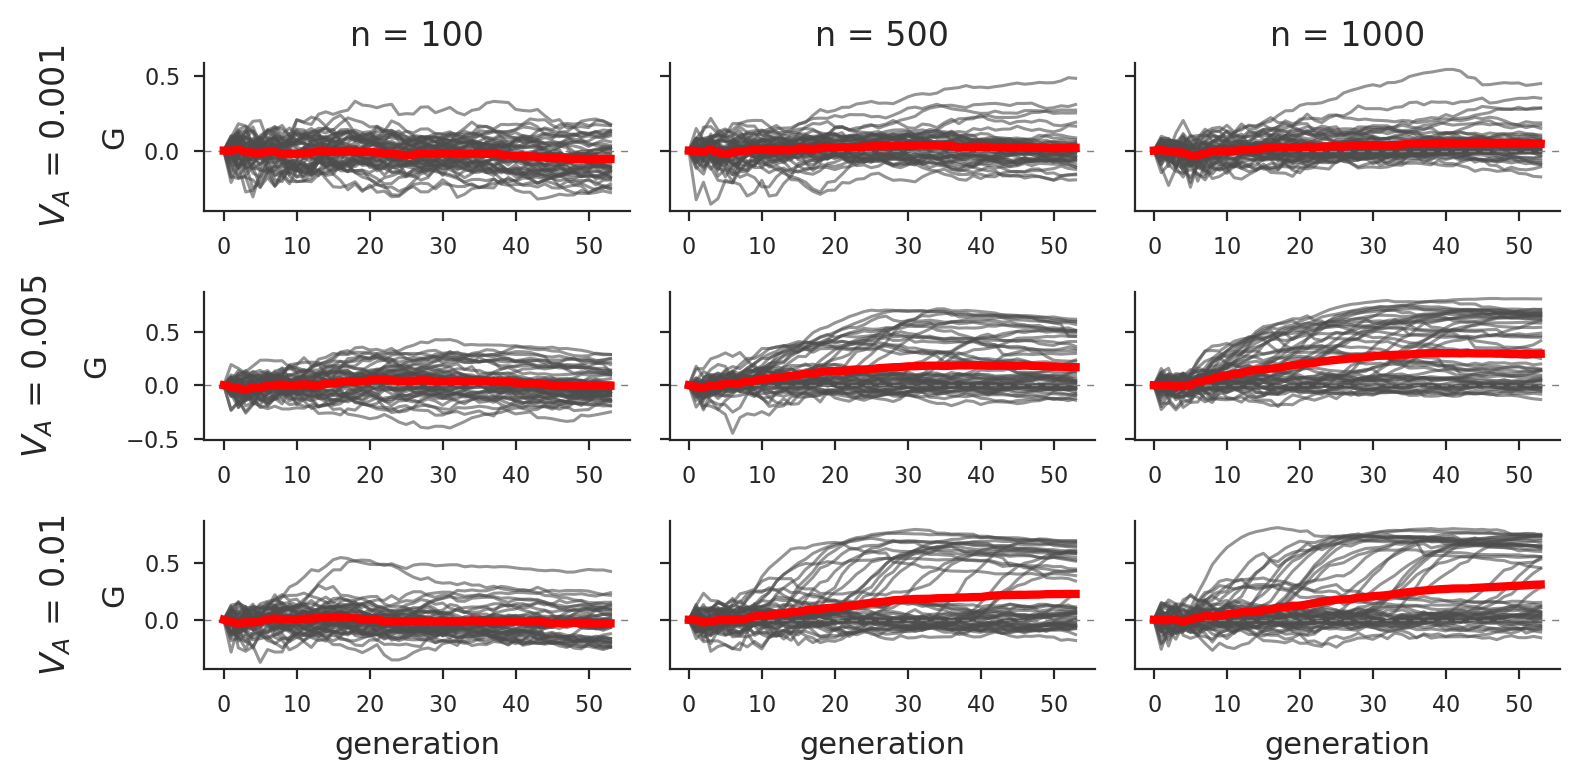

In [253]:
covs_subset_sampleN = extract_runs({'mag': [1.0], 'sampleN': [100, 500, 1000],
                                    'Va': [0.001, 0.005, 0.01],
                                    'shifttype': ['converge'], 'L': [1000]},
                                     expfit_results)

params_sampleN = params_vary_over(covs_subset_sampleN)

fig, ax = plt.subplots(nrows = 3, ncols=3, sharey='row')

sampleNs = sorted(params_sampleN['sampleN'])
Vas = sorted(params_sampleN['Va'])
pad = 5

for i, Va in enumerate(Vas):
    for j, n in enumerate(sampleNs):
        d = extract_runs({'Va':[Va], 'sampleN':[n]}, covs_subset_sampleN)
        assert(len(d.keys()) == 1)
        all = []
        for run in list(d.values())[0]:
            ax[i, j].plot(run[1][:, 0], c='0.3', alpha=0.6)
            if j == 0:
                ax[i, j].set_ylabel('G')
            if i == 2:
                ax[i, j].set_xlabel('generation')
            all.append(run[1][:, 0])
        ax[i, j].axhline(0, c='0.5', linewidth=0.5, linestyle=(0, (5, 5)))   
        ax[i, j].plot(np.stack(all).mean(axis=0), c='r', linewidth=3)
        if i == 0:
            ax[i, j].set_title(f"n = {n}")
    ax[i, 0].annotate(f"$V_A$ = {Va}", xy=(0, 0.5), 
                      xytext=(-ax[i, 0].yaxis.labelpad - pad, 0),
                      xycoords=ax[i, 0].yaxis.label, textcoords='offset points',
                      size='large', ha='right', va='center', rotation=90)
                    
plt.tight_layout()

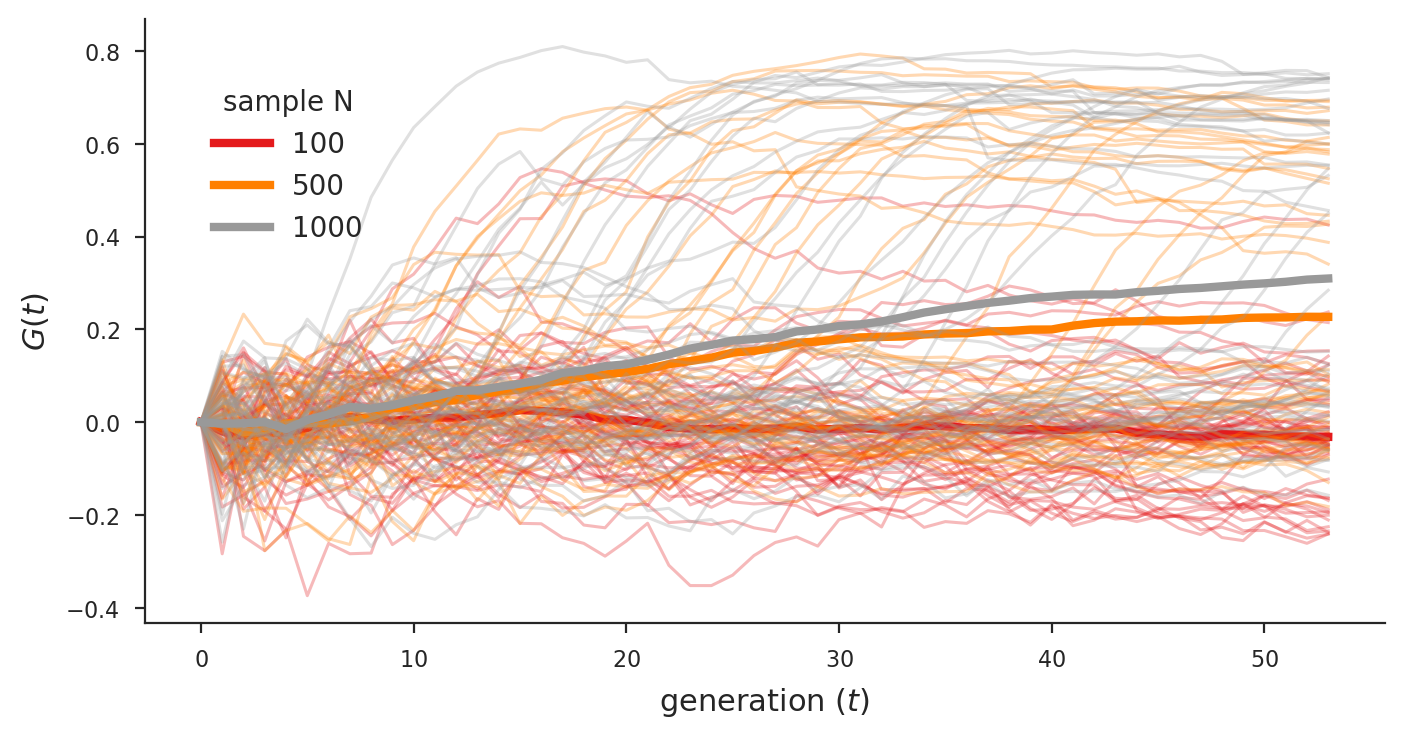

In [254]:
# alternate version of above:
covs_subset_sampleN2 = extract_runs({'mag': [1.0], 'sampleN': [100, 500, 1000],
                                    'Va': [0.01],
                                    'shifttype': ['converge'], 'L': [1]},
                                     expfit_results)

params_sampleN2 = params_vary_over(covs_subset_sampleN)
sampleN_cols = col_palette(params_sampleN2['sampleN'], cm.Set1)

fig, ax = plt.subplots(nrows = 1, ncols=1)

sampleNs2 = sorted(params_sampleN['sampleN'])

for i, sampleN in enumerate(sampleNs2):
    d = extract_runs({'sampleN':[sampleN]}, covs_subset_sampleN2)
    assert(len(d.keys()) == 1)
    all = []
    for run in list(d.values())[0]:
        ax.plot(run[1][:, 0], c=sampleN_cols[sampleN], alpha=0.3)
        all.append(run[1][:, 0])
    ax.plot(np.stack(all).mean(axis=0), c=sampleN_cols[sampleN], label=sampleN, linewidth=3)

ax.set_ylabel('$G(t)$')
ax.set_xlabel('generation ($t$)')
ax.legend(title = 'sample N')


In [ ]:
fig, ax = plt.subplots(nrows = 3, ncols=3, sharey='row')

Ls = sorted(subset_params['L'])
Vas = sorted(subset_params['Va'])
pad = 5

for i, L in enumerate(Ls):
    for j, Va in enumerate(Vas):
        d = extract_runs({'Va':[Va], 'L':[L]}, covs_subset)
        assert(len(d.keys()) == 1)
        all = []
        for run in list(d.values())[0]:
            ax[i, j].plot(run[1][:, 0], c='0.3', alpha=0.6)
            #ax[i, j].set_title(f"L = {L}, Va = {Va}")
            if j == 0:
                ax[i, j].set_ylabel('G')
            if i == 2:
                ax[i, j].set_xlabel('generation')
            all.append(run[1][:, 0])
        ax[i, j].axhline(0, c='0.5', linewidth=0.5, linestyle=(0, (5, 5)))   
        ax[i, j].plot(np.stack(all).mean(axis=0), c='r', linewidth=3)
        if i == 0:
            ax[i, j].set_title(f"$V_A$ = {Va}")
    ax[i, 0].annotate(f"L = {L}", xy=(0, 0.5), 
                      xytext=(-ax[i, 0].yaxis.labelpad - pad, 0),
                      xycoords=ax[i, 0].yaxis.label, textcoords='offset points',
                      size='large', ha='right', va='center', rotation=90)
                    
plt.tight_layout()
fig.savefig("plots/fig-architecture-G.pdf", bbox_inches='tight')

### Covariances

In [18]:
stacked_covs_subset = average_runs(covs_subset)

/home/vsb/miniconda3/envs/cvtk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


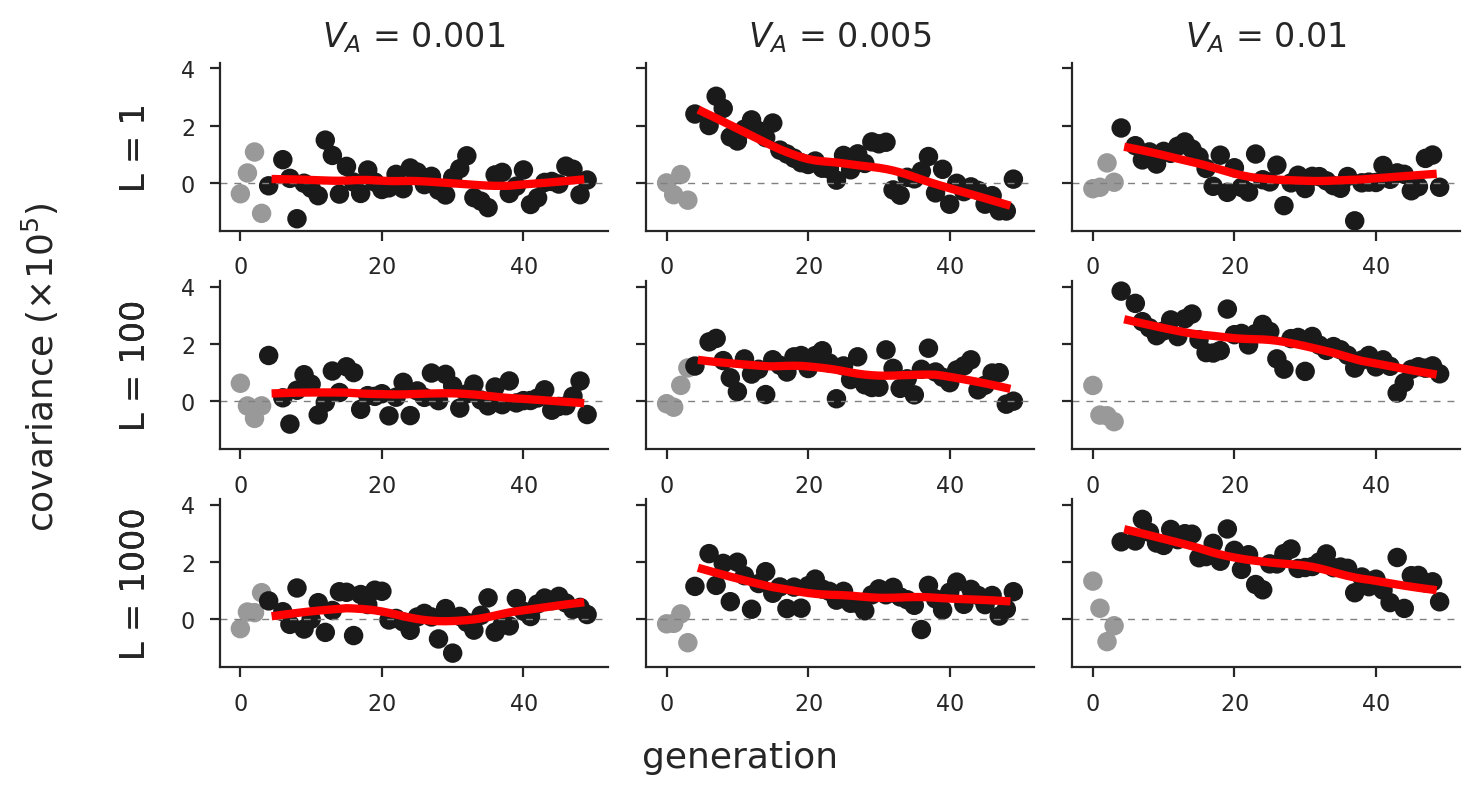

In [203]:
fig, ax = plt.subplots(nrows = 3, ncols=3, sharey=True)

Ls = sorted(subset_params['L'])
Vas = sorted(subset_params['Va'])

lightgray, darkgray = (0.6, 0.6, 0.6), (0.1, 0.1, 0.1)
#lightgray, darkgray = '0.7', '0.3'
maxgen = 50
ref = 5
pad = 10
yscale = 1e5

for i, L in enumerate(Ls):
    for j, Va in enumerate(Vas):
        d = extract_runs({'Va':[Va], 'L':[L]}, stacked_covs_subset)
        assert(len(d.keys()) == 1)
        # this essentially unnests the single element
        for run in list(d.values()):            
            tempcovs = stack_temporal_covariances(run[0].mean(axis=0), run[3][0], run[3][1])
            n = tempcovs[0].shape[0]
            idx = (np.arange(n) != ref) & (np.arange(n) < maxgen)
            ax[i, j].axhline(0, c='0.5', linewidth=0.5, linestyle=(0, (5, 5)))
            cols = [lightgray if i < ref-1 else darkgray for i in range(maxgen-1)]
            selgen = np.arange(ref, maxgen-1)
            fit = lowess(tempcovs[ref, idx, 1][selgen],
                         selgen, frac=1/2, return_sorted=True)
            
            ax[i, j].plot(fit[:, 0], yscale * fit[:, 1], '-', c='red', linewidth=3)
            ax[i, j].scatter(np.where(idx)[0], yscale * tempcovs[ref, idx, 1], c=cols)
            #ax[i, j].set_title(f"L = {L}, Va = {Va}")
        if i == 0:
            ax[i, j].set_title(f"$V_A$ = {Va}")
        ax[i, 0].annotate(f"L = {L}", xy=(0, 0.5), 
                         xytext=(ax[i, 0].yaxis.labelpad - pad, 0),
                         xycoords=ax[i, 0].yaxis.label, textcoords='offset points',
                         size='large', ha='right', va='center', rotation=90)
        
fig.subplots_adjust(right=0.9, hspace=0.3, wspace=0.1)
fig.text(0, 0.5, f"covariance ($\\times 10^{int(np.log10(yscale))}$)", va="center", fontsize=13, rotation='vertical')
fig.text(0.45, 0, "generation", ha="center", fontsize=13)
fig.savefig("plots/fig-architecture-cov.pdf", bbox_inches='tight')

## Convergent Correlations

In [270]:
covs_2pop_subset = extract_runs({'mag': [1.0], 'Va': [0.01],
                                'L': [1, 10, 100, 1000],
                                'sampleN':[50, 500, 1000]},
                                expfit_results)

In [271]:
covs_2pop_ave = average_runs(covs_2pop_subset)

/home/vsb/miniconda3/envs/cvtk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [272]:
params_2pop = params_vary_over(covs_2pop_ave)

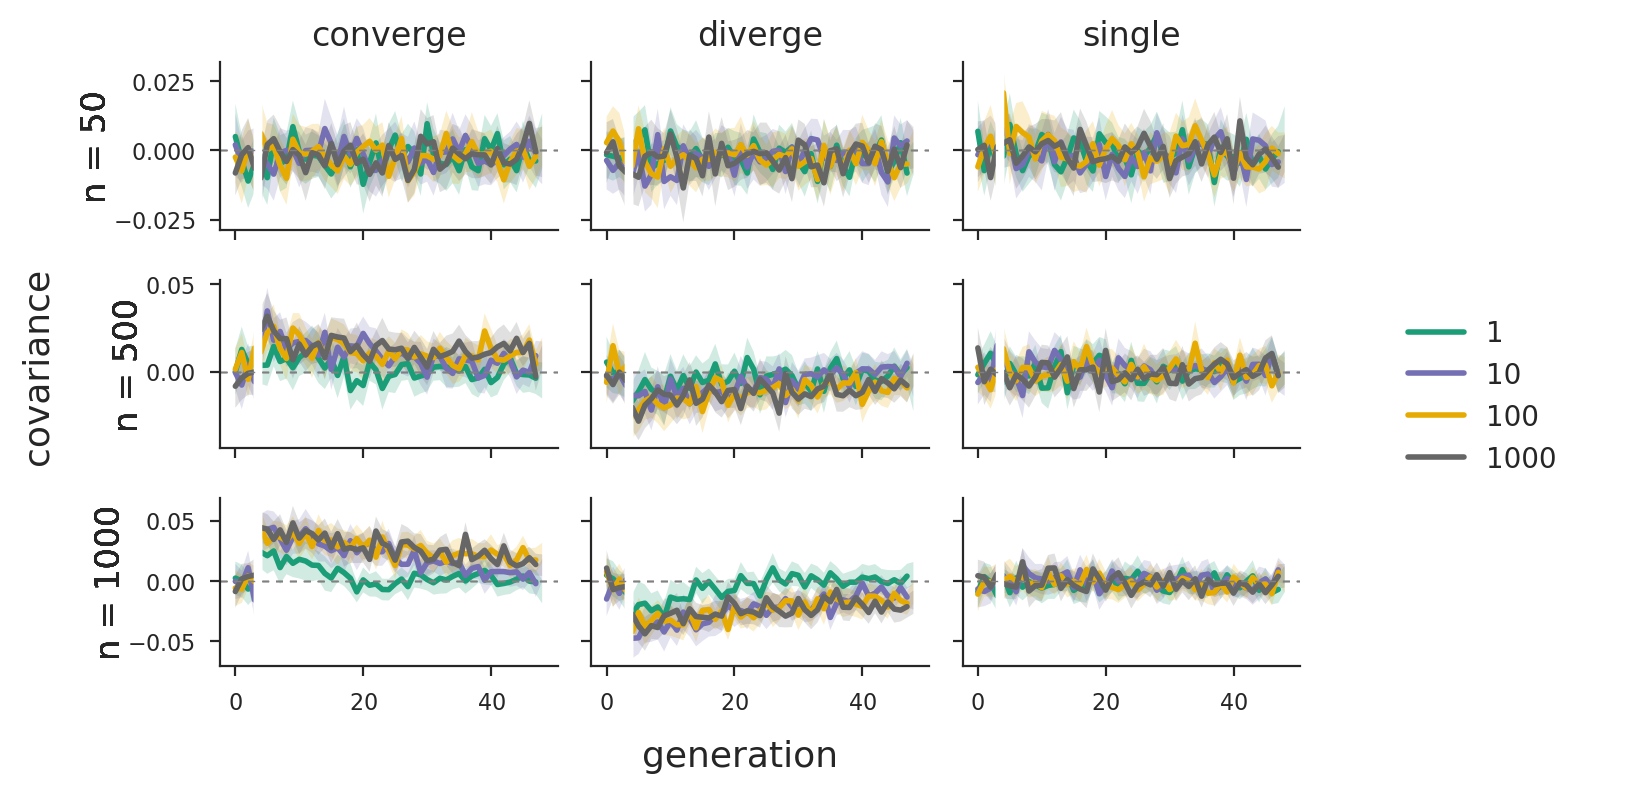

In [275]:
sampleNs = sorted(params_2pop['sampleN'])
modes = sorted(params_2pop['shifttype'])
Ls = sorted(params_2pop['L'])
L_cols = col_palette(params_2pop['L'], cm.Dark2)

ALPHA = 0.05
fig, ax = plt.subplots(nrows = len(sampleNs), ncols=len(modes), 
                       sharey='row', sharex=True)
ref = 5
CI_ALPHA = 0.2
lightgray, darkgray = (0.6, 0.6, 0.6), (0.1, 0.1, 0.1)
pad = 0
use_loess=False
labs = set()

for i, sampleN in enumerate(sampleNs):
    for j, mode in enumerate(modes):
        for L in Ls:
            d = extract_runs({'shifttype':[mode], 'sampleN':[sampleN], 'L':[L]}, covs_2pop_ave)
            assert(len(d.keys()) == 1)
            col = L_cols[L]
            for run in list(d.values()):
                cors = run[2][:, 0, ...]
                cor_ave = cors.mean(axis=0)
                n = cor_ave.shape[0]

                idx = (np.arange(n) != ref) & (np.arange(n) < maxgen)
                cor_CI_sim = np.quantile(cors, (ALPHA/2, 1-ALPHA/2), axis=0)
                cor_sd = np.sqrt(np.var(cors, axis=0))
                N = cors.shape[0]
                cor_CI = np.stack((cor_ave - 2 * cor_sd/np.sqrt(N), 
                                   cor_ave + 2 * cor_sd/np.sqrt(N)))
                cor_poly = CI_polygon(np.arange(maxgen-1), 
                            cor_CI[0, ref, idx], cor_CI[1, ref, idx],
                            color=col, alpha=CI_ALPHA,
                            frac=1/3,
                            linewidth=0, smooth=False)
                cor_poly2 = CI_polygon(np.arange(maxgen-1), 
                            cor_CI_sim[0, ref, idx], cor_CI_sim[1, ref, idx],
                            color=col, alpha=0.05,
                            frac=1/3,
                            linewidth=0, smooth=False)
                ax[i, j].add_patch(cor_poly)
                #ax[i, j].add_patch(cor_poly2)
                l1 = np.where((np.arange(n) < ref-1) & (np.arange(n) < maxgen))[0]
                ax[i, j].plot(l1, cor_ave[ref, idx][l1], '-', c=col,
                              solid_capstyle='round',
                              linewidth=2)

                l2 = np.where((np.arange(n) > ref-1) & (np.arange(n) < maxgen-1))[0]
                if use_loess:
                    fit = lowess(cor_ave[ref, idx][l2-1], l2, frac=1/4)
                    ax[i, j].plot(fit[:, 0], fit[:, 1],  c=col, 
                                  linewidth=3,
                                  solid_capstyle='round')
                else:
                    ax[i, j].plot(l2-1, cor_ave[ref, idx][l2-1], '-',  c=col,
                                  linewidth=2, label=L if L not in labs else None,
                                  solid_capstyle='round')
                if i == 0:
                    ax[i, j].set_title(f"{mode}")
                ax[i, j].axvline(ref-1.5, c='1', linewidth=3)
                ax[i, j].axhline(0, c='0.5', linewidth=0.5, linestyle=(0, (5, 5)))
                ax[i, 0].annotate(f"n = {sampleN}", xy=(0, 0.5), 
                                  xytext=(ax[i, 0].yaxis.labelpad - pad, 0),
                                  xycoords=ax[i, 0].yaxis.label, textcoords='offset points',
                             size='large', ha='right', va='center', rotation=90)
                #ax[i, j].set_ylim(-0.05, 0.05)
            labs.add(L)

fig.subplots_adjust(right=0.8, hspace=0.3, wspace=0.1)
fig.text(0, 0.5, "covariance", va="center", fontsize=13, rotation='vertical')
fig.text(0.45, 0, "generation", ha="center", fontsize=13)
fig.legend(loc = 7, frameon=False, ncol=1)
fig.subplots_adjust(right=0.8, wspace=0.1)
fig.savefig("plots/fig-convergence-corrs.pdf", bbox_inches='tight')


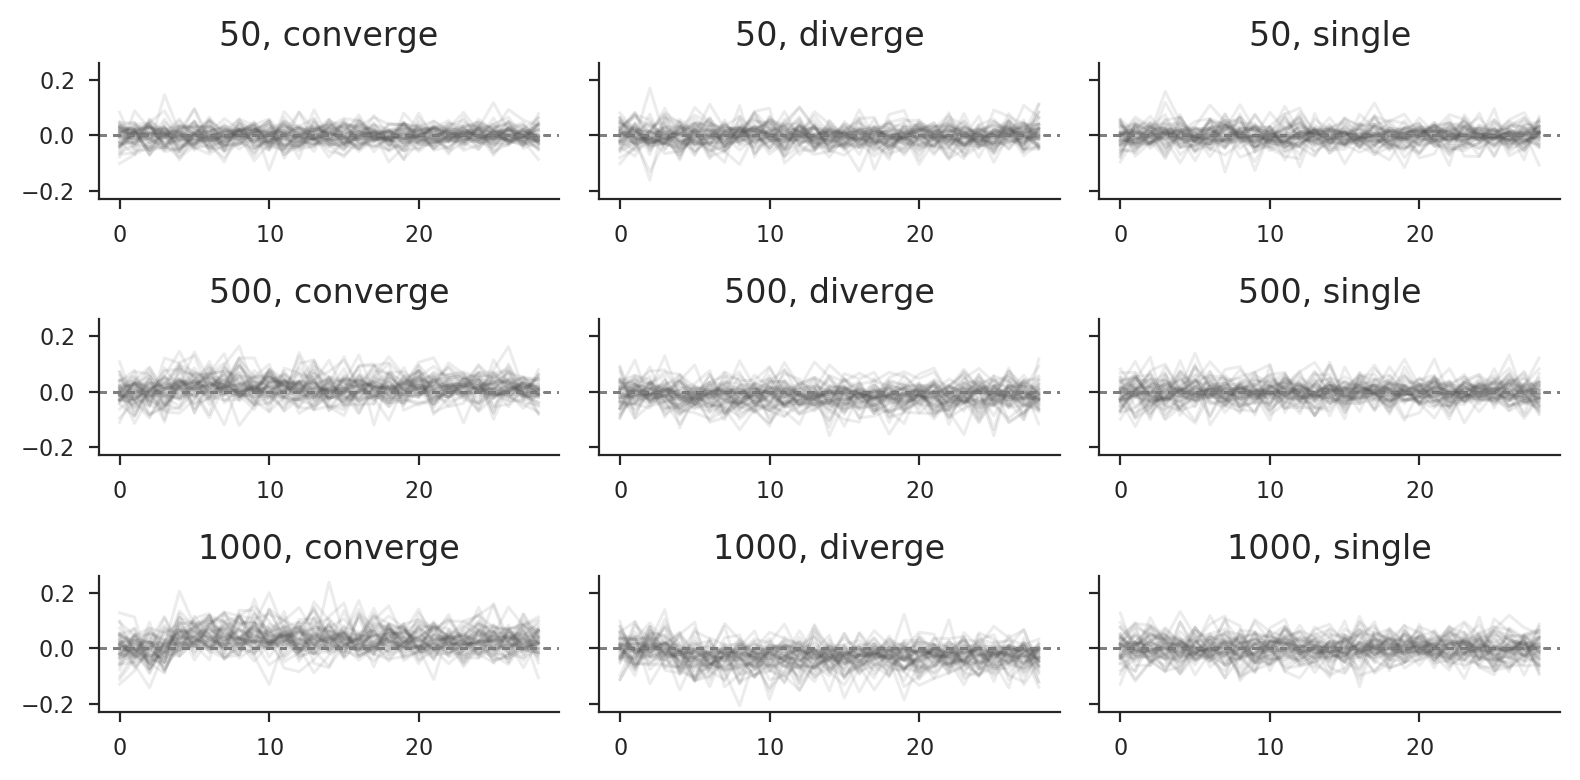

In [118]:
sampleNs = sorted(params_2pop['sampleN'])
modes = sorted(params_2pop['shifttype'])
maxgen = 30
fix, ax = plt.subplots(nrows = len(sampleNs), ncols=len(modes), sharey=True)

for i, sampleN in enumerate(sampleNs):
    for j, mode in enumerate(modes):
        d = extract_runs({'shifttype':[mode], 'sampleN':[sampleN]}, covs_2pop_subset)
        assert(len(d.keys()) == 1)
        for run in list(d.values())[0]:
            ref = 4
            n = run[2][0, :, :].shape[0]
            idx = (np.arange(n) != ref) & (np.arange(n) < maxgen)
            ax[i, j].plot(run[2][0, ref, idx], c='0.3', alpha=0.1)
            ax[i, j].axhline(0, c='0.5', linewidth=0.5, linestyle=(0, (5, 5)))
            ax[i, j].set_title(f"{sampleN}, {mode}")
plt.tight_layout()

## Confidence Intervals

In [381]:
files = {
    '1000': ("../data/sims/split_exp/split_exp_1000N_1e-08rbp_0.01Va_0.009043alpha_1e-08nmu_6.114e-10tmu_1000L_1mag_5shifttime_convergeshifttype_1000sampleN_0_subpop1_neutfreqs.tsv",
             "../data/sims/split_exp/split_exp_1000N_1e-08rbp_0.01Va_0.009043alpha_1e-08nmu_6.114e-10tmu_1000L_1mag_5shifttime_convergeshifttype_1000sampleN_0_subpop2_neutfreqs.tsv"),
    '500': ("../data/sims/split_exp/split_exp_1000N_1e-08rbp_0.01Va_0.009043alpha_1e-08nmu_6.114e-10tmu_1000L_1mag_5shifttime_convergeshifttype_500sampleN_0_subpop1_neutfreqs.tsv",
             "../data/sims/split_exp/split_exp_1000N_1e-08rbp_0.01Va_0.009043alpha_1e-08nmu_6.114e-10tmu_1000L_1mag_5shifttime_convergeshifttype_500sampleN_0_subpop2_neutfreqs.tsv"),
    '100': ("../data/sims/split_exp/split_exp_1000N_1e-08rbp_0.01Va_0.009043alpha_1e-08nmu_6.114e-10tmu_1000L_1mag_5shifttime_convergeshifttype_100sampleN_0_subpop1_neutfreqs.tsv",
             "../data/sims/split_exp/split_exp_1000N_1e-08rbp_0.01Va_0.009043alpha_1e-08nmu_6.114e-10tmu_1000L_1mag_5shifttime_convergeshifttype_100sampleN_0_subpop2_neutfreqs.tsv"),    
    '50': ("../data/sims/split_exp/split_exp_1000N_1e-08rbp_0.01Va_0.009043alpha_1e-08nmu_6.114e-10tmu_1000L_1mag_5shifttime_convergeshifttype_50sampleN_0_subpop1_neutfreqs.tsv", 
          "../data/sims/split_exp/split_exp_1000N_1e-08rbp_0.01Va_0.009043alpha_1e-08nmu_6.114e-10tmu_1000L_1mag_5shifttime_convergeshifttype_50sampleN_0_subpop2_neutfreqs.tsv")}

In [382]:
tile_width = 10e6
tiles = GenomicIntervals.from_tiles({'1': 50e6}, width=tile_width)

In [383]:
tiled_objs = {}
cis = {}
for key, (file1, file2) in files.items():
    d = covs_from_twopop((file1, file2), return_object=True)
    tiled_objs[key] = TiledTemporalFreqs(freqs=d.freqs.reshape((d.freqs.shape[0] * 
                                               d.freqs.shape[1], 
                                               d.freqs.shape[2])),
                                          gintervals=d.gintervals,
                                         samples=d.samples, tiles=tiles)
    cis[key] = tiled_objs[key].bootstrap_convergence_corr(B=1000)

/home/vsb/projects/cvtk/cvtk/bootstrap.py:87: RuntimeWarning: invalid value encountered in true_divide
  stat = estimator(exp_numerator, exp_denominator, **kwargs)


In [384]:
cis['1000'][:, 0, 5, :4]

array([[-0.0531349 , -0.01396405,  0.04034766,  0.04903123],
       [-0.05313499, -0.01396336,  0.04034759,  0.04903246],
       [-0.0531349 , -0.01396405,  0.04034766,  0.04903123]])

In [385]:
cis['50'][:, 0, 5, :4]

array([[-0.00243614,  0.0186494 ,  0.0640909 , -0.00314724],
       [-0.00243336,  0.018646  ,  0.06409195, -0.00314905],
       [-0.00243614,  0.0186494 ,  0.0640909 , -0.00314724]])

In [391]:
(cis['1000'][1, 0, 5, :] - cis['1000'][0, 0, 5, :]).mean()

5.096875546109616e-08

In [392]:
(cis['500'][1, 0, 5, :] - cis['500'][0, 0, 5, :]).mean()

4.41451274471031e-07

In [393]:
(cis['100'][1, 0, 5, :] - cis['100'][0, 0, 5, :]).mean()

8.06871578852303e-08

In [394]:
(cis['50'][1, 0, 5, :] - cis['50'][0, 0, 5, :]).mean()

-5.443150427192518e-08

In [388]:
cis['500'][1, 0, 5, :4] - cis['500'][0, 0, 5, :4] 

array([-1.02270870e-06, -4.87590821e-07, -4.98921226e-07,  6.17448503e-08])

In [389]:
cis['100'][1, 0, 5, :4] - cis['100'][0, 0, 5, :4] 

array([-2.67904672e-06,  2.95933188e-06,  3.38905823e-07, -2.23791136e-06])

In [387]:
cis['50'][1, 0, 5, :4] - cis['50'][0, 0, 5, :4] 

array([ 2.78016465e-06, -3.40167986e-06,  1.05279096e-06, -1.80761891e-06])